# Visualizing Unobserved Confounding Variables
Here, we generate GP visualizations on the map to analyze the locations of unobserved confounding variables.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
import pandas as pd
import os

In [2]:
BASE_PATH = "../results"

## F1

In [3]:
f1_results = pd.read_csv(os.path.join(BASE_PATH, "cv/f1/results.csv"))

In [4]:
f1_results.head()

,fold,iter,ndvi_ls,albedo_ls,train_ridge_score,train_gp_score,train_score,val_ridge_score,val_gp_score,val_score,...,beta_14,beta_15,beta_16,beta_17,beta_18,intercept,matern_const,matern_ls,dp_const,dot_prod_sigma
0,0,0,1,1,0.506009,0.901279,0.951233,0.057187,0.101355,0.169613,...,1.472003,-0.084916,-0.117896,0.290287,0.010359,0.0,0.707107,115.0,0.000548,0.1
1,0,1,1,1,0.504524,0.877540,0.939325,0.066681,0.071460,0.151505,...,1.320473,-0.060014,-0.073252,0.001724,0.012670,0.0,0.707107,115.0,0.000548,0.1
2,0,2,1,1,0.503671,0.907268,0.953977,0.076250,0.118990,0.204601,...,1.208141,-0.018850,-0.135076,-0.003347,-0.034449,0.0,0.707107,115.0,0.000548,0.1
3,0,3,1,1,0.502220,0.877413,0.938980,0.100084,0.006543,0.124769,...,1.121946,0.004692,-0.154630,0.071821,-0.116341,0.0,0.707107,115.0,0.000548,0.1
4,0,4,1,1,0.499165,0.884023,0.941924,0.075287,0.049164,0.136391,...,0.928439,-0.033456,-0.121041,-0.089193,-0.026591,0.0,0.707107,115.0,0.000548,0.1


In [5]:
f1_best_result = f1_results[f1_results["val_ridge_score"]==0.5892698651572632]
f1_best_result.head()

,fold,iter,ndvi_ls,albedo_ls,train_ridge_score,train_gp_score,train_score,val_ridge_score,val_gp_score,val_score,...,beta_14,beta_15,beta_16,beta_17,beta_18,intercept,matern_const,matern_ls,dp_const,dot_prod_sigma
26017,4,7,21,18,0.413354,0.902049,0.942578,0.58927,0.403046,0.755216,...,1.305375,-0.074132,-0.445138,-0.06105,-0.117642,0.0,0.707107,115.0,0.000548,0.1


Now that we have recovered the parameters from the first run of optimizing the length scales, we generate predictions based on this model from **F1**.

In [6]:
import sys
sys.path.append("../")
from src.utils import (
    load_dataset,
    create_folds,
    standardize_data,
    generate_data,
    create_weight_matrix,
)

In [7]:
data_dir = "../data/boston/"
city = "boston"

In [22]:
window_size = 25
ndvi_ls = 21
albedo_ls = 18
l2_alpha = 1
noise = 0.1 # noise

In [9]:
data = load_dataset(data_dir, window_size, city)

In [10]:
idx = range(len(data.coords))
X, y = generate_data(data, idx, ndvi_ls, albedo_ls, window_size, False)

In [11]:
# Normalize the data
x_shift = X.min(axis=0)
x_scale = X.max(axis=0) - X.min(axis=0)

# Add in a small number 1e-8 to prevent divide by zero errors
x_train = (X - x_shift) / (x_scale + 1e-16)

# Standardize the labels
y_mean = y.mean()
y_std = y.std()

y_train = (y - y_mean) / (y_std)

In [12]:
# Needed for the GP
from scipy.optimize import minimize

def optimizer(obj_func, initial_theta, bounds):

    opt_res =  minimize(obj_func, initial_theta, method='L-BFGS-B', bounds=bounds, jac=True, options = {'maxiter':1000})    

    return opt_res.x, opt_res.fun

In [13]:
# SKLEARN modules
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.interpolate import griddata

In [23]:
ridge_y = y_train
current_score = 1
for i in range(20):
    print("iteration ", i)
    lm = Ridge(alpha=l2_alpha, fit_intercept=False).fit(x_train, ridge_y)
    preds = lm.predict(x_train)

    print("\t Ridge R2 score: ", r2_score(y_train, preds))
    if r2_score(y_train, preds) > current_score:
        break
    current_score = r2_score(y_train, preds)
    coords = data.coords

    residuals = y_train - preds

    N = 1000
    sample_idx = np.random.choice(np.arange(coords.shape[0]), N, replace=False)
    sample_points = coords[sample_idx, :]
    sample_residuals = residuals[sample_idx]

    kernel = (kernels.ConstantKernel(0.5, 'fixed')*kernels.Matern(length_scale=115, nu=0.5, length_scale_bounds='fixed')+ kernels.ConstantKernel(3e-7, 'fixed')*kernels.DotProduct(0.1, 'fixed'))
    gpr = GaussianProcessRegressor(kernel = kernel, alpha=noise, random_state=100, n_restarts_optimizer=10)

    gpr.fit(sample_points, sample_residuals)

    U = gpr.predict(coords)
    ridge_y = y_train - U

iteration  0
	 Ridge R2 score:  0.48028142352453496
iteration  1
	 Ridge R2 score:  0.47667365989850985
iteration  2
	 Ridge R2 score:  0.47224516766300906
iteration  3
	 Ridge R2 score:  0.4630315971458364
iteration  4
	 Ridge R2 score:  0.4532799458303437
iteration  5
	 Ridge R2 score:  0.4437652548208586
iteration  6
	 Ridge R2 score:  0.4374681388355536
iteration  7
	 Ridge R2 score:  0.42511789256796306
iteration  8
	 Ridge R2 score:  0.4209150063479806
iteration  9
	 Ridge R2 score:  0.40648185146690163
iteration  10
	 Ridge R2 score:  0.3913741989176821
iteration  11
	 Ridge R2 score:  0.38398818903211307
iteration  12
	 Ridge R2 score:  0.37846081776809326
iteration  13
	 Ridge R2 score:  0.37070388177877767
iteration  14
	 Ridge R2 score:  0.3690501661806418
iteration  15
	 Ridge R2 score:  0.36962722970289486


In [15]:
print(lm.score(x_train, y_train)) # Noise=1e-4

0.4376395362536266


In [24]:
print(lm.score(x_train, y_train)) # Noise=0.1

0.36962722970289486


In [16]:
x = np.arange(0, data.ndvi.shape[0])
y = np.arange(0, data.ndvi.shape[1])

# Get the meshgrid of the points
(x_grid, y_grid) = np.meshgrid(x, y)

# Downsample the points, by only getting every 10th point
ds = 10
x_downsample = x_grid[::ds, ::ds]
y_downsample = y_grid[::ds, ::ds]

# Stack the x and y coordinates
all_coords = np.vstack((x_downsample.flatten(), y_downsample.flatten())).T

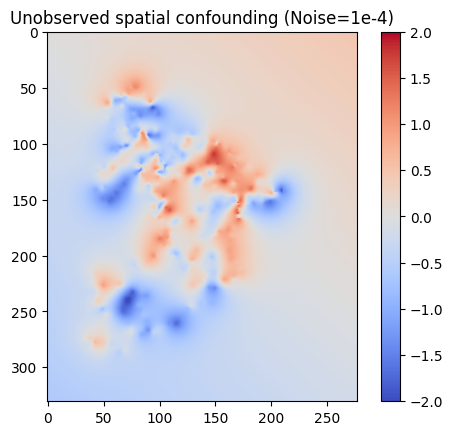

In [17]:
# Noise = 1e-4
U = gpr.predict(all_coords)
plt.imshow(U.reshape(x_downsample.shape).T, cmap='coolwarm', vmin=-2, vmax=2)
plt.title("F1 Results: Unobserved spatial confounding (Noise=1e-4)")
plt.colorbar()

In [21]:
U = gpr.predict(coords)
r2_score(y_train, preds + U)

0.9379263940872854

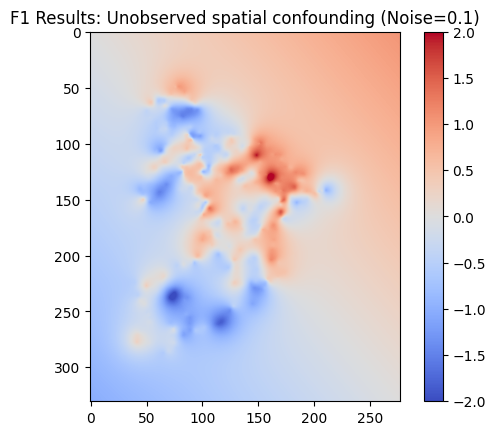

In [25]:
# Noise = 0.1
U = gpr.predict(all_coords)
plt.imshow(U.reshape(x_downsample.shape).T, cmap='coolwarm', vmin=-2, vmax=2)
plt.title("F1 Results: Unobserved spatial confounding (Noise=0.1)")
plt.colorbar()

In [27]:
np.max(U)

2.6597958070090932

In [28]:
U = gpr.predict(coords)
r2_score(y_train, preds + U)

0.9193195801059403

## F2

In [29]:
f2_results = pd.read_csv(os.path.join(BASE_PATH, "cv/f2/results.csv"))

In [30]:
f2_results.head()

,fold,iter,ndvi_ls,albedo_ls,train_ridge_score,train_gp_score,train_score,val_ridge_score,val_gp_score,val_score,...,beta_14,beta_15,beta_16,beta_17,beta_18,intercept,matern_const,matern_ls,dp_const,dot_prod_sigma
0,0,0,1,1,0.504942,0.887194,0.944155,0.079920,-0.002213,0.097995,...,1.347347,-0.064063,-0.210882,0.213741,-0.000598,0.0,0.707107,115.0,0.000548,0.1
1,0,1,1,1,0.498899,0.884595,0.942172,0.122672,-0.017241,0.130071,...,0.983152,0.004944,-0.358673,0.004185,-0.120780,0.0,0.707107,115.0,0.000548,0.1
2,0,2,1,1,0.494383,0.894309,0.946575,0.140472,0.068429,0.218627,...,0.863679,-0.004146,-0.312130,-0.040290,-0.121241,0.0,0.707107,115.0,0.000548,0.1
3,0,3,1,1,0.490093,0.880621,0.939131,0.157310,0.050895,0.225430,...,0.878320,0.024015,-0.296241,0.003337,-0.207783,0.0,0.707107,115.0,0.000548,0.1
4,0,4,1,1,0.484453,0.909168,0.953174,0.171974,0.063787,0.253868,...,0.716104,0.042981,-0.274905,0.010998,-0.245655,0.0,0.707107,115.0,0.000548,0.1


In [40]:
ndvi_ls = 27
albedo_ls = 11
l2_alpha = 10
noise = 0.1 # noise

In [43]:
idx = range(len(data.coords))
X, y = generate_data(data, idx, ndvi_ls, albedo_ls, window_size, False)

# Normalize the data
x_shift = X.min(axis=0)
x_scale = X.max(axis=0) - X.min(axis=0)

# Add in a small number 1e-8 to prevent divide by zero errors
x_train = (X - x_shift) / (x_scale + 1e-16)

# Standardize the labels
y_mean = y.mean()
y_std = y.std()

y_train = (y - y_mean) / (y_std)

In [45]:
ridge_y = y_train
current_score = 1
for i in range(20):
    print("iteration ", i)
    lm = Ridge(alpha=l2_alpha, fit_intercept=False).fit(x_train, ridge_y)
    preds = lm.predict(x_train)

    print("\t Ridge R2 score: ", r2_score(y_train, preds))
    if r2_score(y_train, preds) > current_score:
        break
    current_score = r2_score(y_train, preds)
    coords = data.coords

    residuals = y_train - preds

    N = 1000
    sample_idx = np.random.choice(np.arange(coords.shape[0]), N, replace=False)
    sample_points = coords[sample_idx, :]
    sample_residuals = residuals[sample_idx]

    kernel = (kernels.ConstantKernel(0.5, 'fixed')*kernels.Matern(length_scale=115, nu=0.5, length_scale_bounds='fixed')+ kernels.ConstantKernel(3e-7, 'fixed')*kernels.DotProduct(0.1, 'fixed'))
    gpr = GaussianProcessRegressor(kernel = kernel, alpha=noise, random_state=100, n_restarts_optimizer=10)

    gpr.fit(sample_points, sample_residuals)

    U = gpr.predict(coords)
    ridge_y = y_train - U

iteration  0
	 Ridge R2 score:  0.4798384603660095
iteration  1
	 Ridge R2 score:  0.473861453950724
iteration  2
	 Ridge R2 score:  0.46328291448342185
iteration  3
	 Ridge R2 score:  0.4545046560012129
iteration  4
	 Ridge R2 score:  0.44447825609623925
iteration  5
	 Ridge R2 score:  0.4301882257608848
iteration  6
	 Ridge R2 score:  0.42510124675351857
iteration  7
	 Ridge R2 score:  0.4162381049113105
iteration  8
	 Ridge R2 score:  0.4037981183734455
iteration  9
	 Ridge R2 score:  0.397956484297478
iteration  10
	 Ridge R2 score:  0.3862489130990445
iteration  11
	 Ridge R2 score:  0.37346467554119733
iteration  12
	 Ridge R2 score:  0.3674700066701395
iteration  13
	 Ridge R2 score:  0.35777473282935657
iteration  14
	 Ridge R2 score:  0.35157598120109423
iteration  15
	 Ridge R2 score:  0.35307072428966113


In [35]:
print(lm.score(x_train, y_train)) # Noise = 1e-4

0.45578463063623376


In [46]:
print(lm.score(x_train, y_train)) # Noise = 0.1

0.35307072428966113


In [118]:
x = np.arange(0, data.ndvi.shape[0])
y = np.arange(0, data.ndvi.shape[1])

# Get the meshgrid of the points
(x_grid, y_grid) = np.meshgrid(x, y)

# Downsample the points, by only getting every 10th point
ds = 10
x_downsample = x_grid[::ds, ::ds]
y_downsample = y_grid[::ds, ::ds]

# Stack the x and y coordinates
all_coords = np.vstack((x_downsample.flatten(), y_downsample.flatten())).T

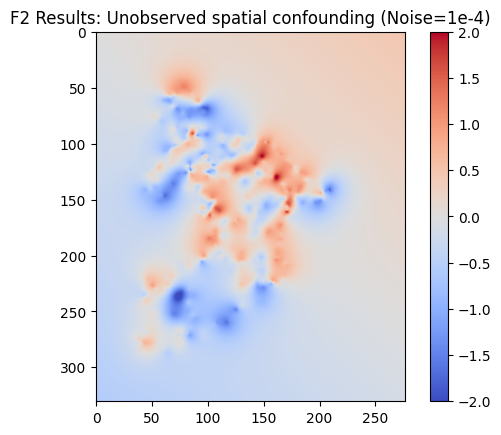

In [36]:
# Noise = 1e-4
U = gpr.predict(all_coords)
plt.imshow(U.reshape(x_downsample.shape).T, cmap='coolwarm', vmin=-2, vmax=2)
plt.title("F2 Results: Unobserved spatial confounding (Noise=1e-4)")
plt.colorbar()

In [38]:
np.max(U)

2.2883702696614563

In [39]:
U = gpr.predict(coords)
r2_score(y_train, preds + U)

0.9369607469740451

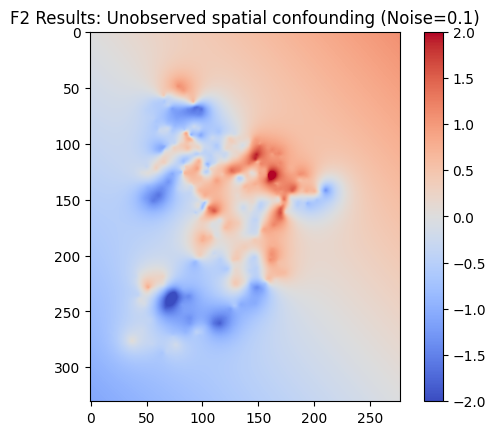

In [48]:
# Noise = 0.1
U = gpr.predict(all_coords)
plt.imshow(U.reshape(x_downsample.shape).T, cmap='coolwarm', vmin=-2, vmax=2)
plt.title("F2 Results: Unobserved spatial confounding (Noise=0.1)")
plt.colorbar()

In [49]:
U = gpr.predict(coords)
r2_score(y_train, preds + U)

0.9271500854311978

In [50]:
print(np.max(U))

3.0644049327795813
